In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

cristianjsanchez_dataset_path = kagglehub.dataset_download('cristianjsanchez/dataset')
cristianjsanchez_resultado_analisis_path = kagglehub.dataset_download('cristianjsanchez/resultado-analisis')
cristianjsanchez_muestras_final_path = kagglehub.dataset_download('cristianjsanchez/muestras-final')

print('Data source import complete.')


In [ ]:
pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 34.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
pd.options.mode.chained_assignment = None
from hdbscan import HDBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator

In [ ]:
df=pd.read_csv('/DATASET.csv')
df.head(10)

,Transaction ID,Originator,Originator_ID,EntryDate,InputOutput,Market,Product ISIN,Product Type,Product Class,Normalized Amount,Currency,Anomaly
0,I9Q3S5YYLCQX,Client_087,_XID,2019-01-01 17:55:33,Sell,Market2,ISN-X01-LRBXBXN,FutureCommodity,Trade,10317357.93,Currency1,0
1,VFZ6INAXVYJV,Client_019,_XID,2019-01-01 18:52:34,Sell,Market1,ISN-X01-856Z8OC,FX,Trade,31042.04,Currency2,0
2,HXOA8DNPX1OE,Client_385,_XID,2019-01-01 15:21:09,Sell,Market1,ISN-X01-5CW2HUF,SimpleTransfer,Trade,35910.53,Currency1,0
3,O9W5IR932XT1,Client_276,_XID,2019-01-01 20:02:36,Sell,Market1,ISN-X01-AQ848H7,FutureEquity,Trade,79630.92,Currency2,0
4,84KF31TPK1LU,Client_049,_XID,2019-01-01 09:06:58,Buy,Market1,ISN-X01-7JWB2C7,FX,Trade,434370.69,Currency1,0
5,A6EAD26IK49P,Client_010,_XID,2019-01-01 09:07:06,Buy,Market4,ISN-X01-U9SBVA7,FX,Trade,431.11,Currency2,0
6,GR4T16G3CJFR,Client_043,_XID,2019-01-01 18:51:21,Sell,Market1,ISN-X01-XLEB16J,FX,Trade,441.55,Currency1,0
7,5PVIQLPTQB9O,Client_033,_XID,2019-01-01 14:12:56,Sell,Market1,ISN-X01-6B2N5M3,FutureOptionEquityIndex,Trade,65399.66,Currency2,0
8,EVQW6NEMUSRK,Client_269,_XID,2019-01-01 20:26:17,Buy,Market1,ISN-X01-UUGSZWQ,FXForward,Trade,370662.13,Currency1,0
9,MC0HQPX4Z4SZ,Client_034,_XID,2019-01-01 14:21:59,Sell,Market1,ISN-X01-QNY2DAD,FutureBond,ADR Conversion,526.67,Currency1,0


In [ ]:
df['EntryDate'] = pd.to_datetime(df['EntryDate'])

In [ ]:
df.shape[0]

29704090

In [ ]:
df2=df.tail(df.shape[0]-20000000)
df=df.head(20000000)

In [ ]:
total_transactions_df2 = df2['Transaction ID'].count()
df2['num_transactions_proportion'] = 1 / total_transactions_df2

df2['EntryDate'] = pd.to_datetime(df2['EntryDate'])
df2['Weekday'] = df2['EntryDate'].dt.weekday
df2['Hour'] = df2['EntryDate'].dt.hour

df2['Morning'] = df2['Hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)  # Mañana (6:00 - 11:59)
df2['Evening'] = df2['Hour'].apply(lambda x: 1 if 12 <= x < 18 else 0)  # Tarde (12:00 - 17:59)
df2['Night'] = df2['Hour'].apply(lambda x: 1 if 18 <= x < 24 or 0 <= x < 6 else 0)  # Noche (18:00 - 23:59), (00:00 - 5:59)

condition_round_amount = ((df2['Normalized Amount'].apply(lambda x: str(x).count('000.0')) >= 1) & (df2['Normalized Amount'] == df2['Normalized Amount'].round()))
df2['Round_Amount_Condition'] = condition_round_amount.astype(int)

condition_small_amount = ((df2['Normalized Amount'] < 1177.44) & (df2['Normalized Amount'] > 420.65) & (df2['Product Class'] == 'Cash in / out (withdrawal), Security in / out'))
df2['Small_Amount_Condition'] = condition_small_amount

condition_sell = df2['InputOutput'] == 'Sell'
df2['Sell_Condition'] = condition_sell
condition_buy = df2['InputOutput'] == 'Buy'
df2['Buy_Condition'] = condition_buy

inoutdelta = (df2['InputOutput'] == 'Buy').astype(int) - (df2['InputOutput'] == 'Sell').astype(int)
df2['InputOutput_Delta'] = inoutdelta

condition_sell_cash = df2['Normalized Amount'].where(condition_sell & (df2['Product Class'] == 'Cash in / out (withdrawal), Security in / out'), 0)
df2['condition_sell_cash'] = condition_sell_cash

condition_sell_cash2 = df2['Normalized Amount'].where(condition_sell & (df2['Product Type'] == 'SimpleTransfer'), 0)
df2['condition_sell_cash2'] = condition_sell_cash2

aggregated_dfte = df2.groupby(['Originator','Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Anomaly']).agg(
    num_transactions=('num_transactions_proportion', 'sum'),
    total_amount_traded=('Normalized Amount', 'mean'),
    transactions_count_small_amount=('Small_Amount_Condition', 'mean'),
    transactions_count_round_amount=('Round_Amount_Condition', 'mean'),
    transactions_count_amount_sell=('Sell_Condition', 'mean'),
    transactions_count_amount_buy=('Buy_Condition', 'mean'),
    cash_out_withdrawal_security_out=('condition_sell_cash', 'mean'),
    simpletranfer=('condition_sell_cash2', 'mean'),
    inputoutput_delta=('InputOutput_Delta', 'mean')
).reset_index()

df2.drop(columns=['Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Round_Amount_Condition', 'Small_Amount_Condition', 'Sell_Condition', 'Buy_Condition', 'InputOutput_Delta', 'condition_sell_cash', 'condition_sell_cash2','num_transactions_proportion'], inplace=True)


In [ ]:
start_date = '2019-01-01'
end_date = '2019-03-25'
date_range = pd.date_range(start=start_date, end=end_date).date

In [ ]:
days=56

In [ ]:
f1scorel=[]
accuracy1=[]
tprl=[]
tnrl=[]
fprl=[]
fnrl=[]
totaltransactions=[]
aggregatedtransactions=[]
reviewedtransactions_total=[]
reviewedtransactions_day=[]
daysf=[]

for i in range(1, days):
    n_test = df[df['EntryDate'].dt.date == date_range[i]].shape[0]

    if n_test == 0:
        continue

    print('Day ',i)
    print('Train transactions from Day 1 to Day ', i, df[df['EntryDate'].dt.date.isin(date_range[:i])].shape[0])
    totaltransactions.append(df[df['EntryDate'].dt.date.isin(date_range[:i])].shape[0])
    #print('Test transactions Day ', i+1, df[df['EntryDate'].dt.date == date_range[i]].shape[0])

    df1=df[df['EntryDate'].dt.date.isin(date_range[:i])]
    #df2=df[df['EntryDate'].dt.date == date_range[i]]

    daysf.append(date_range[i-1])

    # dataframe TRAIN

    total_transactions_df1 = df1['Transaction ID'].count()
    df1['num_transactions_proportion'] = 1 / total_transactions_df1

    df1['EntryDate'] = pd.to_datetime(df1['EntryDate'])
    df1['Weekday'] = df1['EntryDate'].dt.weekday
    df1['Hour'] = df1['EntryDate'].dt.hour

    df1['Morning'] = df1['Hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)  # Mañana (6:00 - 11:59)
    df1['Evening'] = df1['Hour'].apply(lambda x: 1 if 12 <= x < 18 else 0)  # Tarde (12:00 - 17:59)
    df1['Night'] = df1['Hour'].apply(lambda x: 1 if 18 <= x < 24 or 0 <= x < 6 else 0)  # Noche (18:00 - 23:59), (00:00 - 5:59)

    condition_round_amount = ((df1['Normalized Amount'].apply(lambda x: str(x).count('000.0')) >= 1) & (df1['Normalized Amount'] == df1['Normalized Amount'].round()))
    df1['Round_Amount_Condition'] = condition_round_amount.astype(int)

    condition_small_amount = ((df1['Normalized Amount'] < 1177.44) & (df1['Normalized Amount'] > 420.65) & (df1['Product Class'] == 'Cash in / out (withdrawal), Security in / out'))
    df1['Small_Amount_Condition'] = condition_small_amount

    condition_sell = df1['InputOutput'] == 'Sell'
    df1['Sell_Condition'] = condition_sell
    condition_buy = df1['InputOutput'] == 'Buy'
    df1['Buy_Condition'] = condition_buy

    inoutdelta = (df1['InputOutput'] == 'Buy').astype(int) - (df1['InputOutput'] == 'Sell').astype(int)
    df1['InputOutput_Delta'] = inoutdelta

    condition_sell_cash = df1['Normalized Amount'].where(condition_sell & (df1['Product Class'] == 'Cash in / out (withdrawal), Security in / out'), 0)
    df1['condition_sell_cash'] = condition_sell_cash

    condition_sell_cash2 = df1['Normalized Amount'].where(condition_sell & (df1['Product Type'] == 'SimpleTransfer'), 0)
    df1['condition_sell_cash2'] = condition_sell_cash2

    aggregated_dftr = df1.groupby(['Originator','Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Anomaly']).agg(
        num_transactions=('num_transactions_proportion', 'sum'),
        total_amount_traded=('Normalized Amount', 'mean'),
        transactions_count_small_amount=('Small_Amount_Condition', 'mean'),
        transactions_count_round_amount=('Round_Amount_Condition', 'mean'),
        transactions_count_amount_sell=('Sell_Condition', 'mean'),
        transactions_count_amount_buy=('Buy_Condition', 'mean'),
        cash_out_withdrawal_security_out=('condition_sell_cash', 'mean'),
        simpletranfer=('condition_sell_cash2', 'mean'),
        inputoutput_delta=('InputOutput_Delta', 'mean')
    ).reset_index()

    df1.drop(columns=['Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Round_Amount_Condition', 'Small_Amount_Condition', 'Sell_Condition', 'Buy_Condition', 'InputOutput_Delta', 'condition_sell_cash', 'condition_sell_cash2','num_transactions_proportion'], inplace=True)

    print ('Aggregated transactions to be reviwed by specialized analysts ', aggregated_dftr.shape[0])
    aggregatedtransactions.append(aggregated_dftr.shape[0])

    # dataframe TEST

    #-------------------------------------------------------------------------------------------------------------------------------------------------

    isolation_forest = IsolationForest(bootstrap=True , contamination=0.01, random_state=42)
    isolation_forest.fit(aggregated_dftr.drop(columns=['Originator','Anomaly']))
    aggregated_dftr['anomaly_score'] = isolation_forest.decision_function(aggregated_dftr.drop(columns=['Originator','Anomaly']))

    top_k_anomalies = 5 # Ajustar
    top_rf_anomalies = aggregated_dftr.nsmallest(top_k_anomalies, 'anomaly_score') ###
    top_rf_anomalies.drop('anomaly_score', axis=1, inplace=True)
    least_rf_anomalies = aggregated_dftr.nlargest(top_k_anomalies, 'anomaly_score') ###
    least_rf_anomalies.drop('anomaly_score', axis=1, inplace=True)

    top_s_anomalies = aggregated_dftr.nsmallest(2000, 'anomaly_score')  # Muestras más anómalas de Isolation Forest
    clusterer = HDBSCAN(min_cluster_size=3)
    top_s_anomalies['cluster'] = clusterer.fit_predict(top_s_anomalies.drop(columns=['Originator','anomaly_score','Anomaly']))
    ##top_s_anomalies=top_s_anomalies[top_s_anomalies['cluster']!=-1]

    samples_per_cluster = 1  # Ajustar
    samples_diverse = top_s_anomalies.groupby('cluster').apply(lambda x: x.nsmallest(samples_per_cluster, 'anomaly_score')).reset_index(drop=True)
    samples_diverse.drop(columns=['cluster','anomaly_score'], axis=1, inplace=True) ###

    combined_samples = pd.concat([top_rf_anomalies, least_rf_anomalies, samples_diverse]).drop_duplicates()
    X_combined = combined_samples.drop(columns=['Originator','Anomaly'])
    y_combined = combined_samples['Anomaly']
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_combined, y_combined)
    aggregated_dftr['rf_score'] = rf_model.predict_proba(aggregated_dftr.drop(columns=['Originator','Anomaly', 'anomaly_score']))[:, 1]

    # Seleccionamos muestras con mayor diferencia entre Isolation Forest y Random Forest.
    aggregated_dftr['conflict_score'] = abs(aggregated_dftr['anomaly_score'] - aggregated_dftr['rf_score'])
    conflict_samples_k = 3  # Ajustar
    conflict_samples = aggregated_dftr.nlargest(conflict_samples_k, 'conflict_score')
    conflict_samples.drop(columns=['rf_score','anomaly_score','conflict_score'], axis=1, inplace=True)

    # Seleccionamos muestras de mayor incertidumbre.
    aggregated_dftr['entropy_score'] = abs(aggregated_dftr['rf_score'] - 0.5)
    entropy_samples_k = 3 # Ajustar
    entropy_samples = aggregated_dftr.nsmallest(entropy_samples_k, 'entropy_score')
    entropy_samples.drop(columns=['rf_score','anomaly_score','conflict_score','entropy_score'], axis=1, inplace=True)

    # Combinamos las muestras obtenidas en el dia o periodo presente.
    combined_samples_f = pd.concat([conflict_samples, entropy_samples, combined_samples]).drop_duplicates() # MUESTRAS QUE REVISA EL ANALISTA.
    reviewedtransactions_day.append(combined_samples_f.shape[0])

    # Combinamos todas las muestras actuales y pasadas para asegurar el aprendizaje.
    if i==1:
        combined_samples_final=combined_samples_f
    combined_samples_final = pd.concat([combined_samples_final, combined_samples_f], ignore_index=True).drop_duplicates()
    X_final_selected = combined_samples_final.drop(columns=['Originator','Anomaly'])
    y_final_selected = combined_samples_final['Anomaly']

    # Entrenamos el modelo Random Forest final.
    rf_model_final = RandomForestClassifier(random_state=42)
    rf_model_final.fit(X_final_selected, y_final_selected)

    # Evaluamos el modelo final con el conjunto de prueba (aggregated_dfte)
    y_pred = rf_model_final.predict(aggregated_dfte.drop(columns=['Originator','Anomaly']))
    conf_matrix = confusion_matrix(aggregated_dfte['Anomaly'], y_pred)
    accuracy = accuracy_score(aggregated_dfte['Anomaly'], y_pred)
    accuracy1.append(accuracy)
    f1 = f1_score(aggregated_dfte['Anomaly'], y_pred, average='macro') # Macro
    f1scorel.append(f1)

    # Metricas Macro

    tprlist = []  # True Positive Rate
    tnrlist = []  # True Negative Rate
    fprlist = []  # False Positive Rate
    fnrlist = []  # False Negative Rate

    num_classes = conf_matrix.shape[0]

    for e in range(num_classes):
        tp = conf_matrix[e, e]  # True Positives para la clase i
        fn = conf_matrix[e, :].sum() - tp  # False Negatives para la clase i
        fp = conf_matrix[:, e].sum() - tp  # False Positives para la clase i
        tn = conf_matrix.sum() - (tp + fp + fn)  # True Negatives

        # Calculamos el TPR, TNR, FPR, FNR para la clase i
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

        # Añadimos las métricas a las listas
        tprlist.append(tpr)
        tnrlist.append(tnr)
        fprlist.append(fpr)
        fnrlist.append(fnr)

    # Ahora podemos calcular el promedio simple (promedio no ponderado)
    tprl.append(np.mean(tprlist))
    tnrl.append(np.mean(tnrlist))
    fprl.append(np.mean(fprlist))
    fnrl.append(np.mean(fnrlist))

    print('Actual aggregated transactions reviwed  by analysts from Day 1 to Day', i, combined_samples_final.shape[0])
    print('Actual aggregated transactions reviwed  by analysts on Day 1', combined_samples_f.shape[0])
    reviewedtransactions_total.append(combined_samples_final.shape[0])
    print('Accuracy ', accuracy)
    print('F1-score ', f1)
    print(conf_matrix)
    print('----------------------------------------------------------------------------------------------------')
    print('                         ')

    del aggregated_dftr
    gc.collect()

Day  1
Train transactions from Day 1 to Day  1 580361
Aggregated transactions to be reviwed by specialized analysts  8222
Actual aggregated transactions reviwed  by analysts from Day 1 to Day 1 172
Actual aggregated transactions reviwed  by analysts on Day 1 172
Accuracy  0.9912614458335075
F1-score  0.6133865075725647
[[46809     0     0     0     0     0]
 [   84   242     0     0     0     0]
 [    2     0   293     0     0     0]
 [  134     0     0    32     0     0]
 [   76     0     0     0    40     0]
 [  122     0     0     0     0     0]]
----------------------------------------------------------------------------------------------------
                         
Day  2
Train transactions from Day 1 to Day  2 1093241
Aggregated transactions to be reviwed by specialized analysts  16221
Actual aggregated transactions reviwed  by analysts from Day 1 to Day 2 341
Actual aggregated transactions reviwed  by analysts on Day 1 169
Accuracy  0.9937492160388008
F1-score  0.69625477805

**Exportar resultados**

In [ ]:
data = {
    'F1_Score': f1scorel,
    'Accuracy': accuracy1,
    'TPR': tprl,
    'TNR': tnrl,
    'FPR': fprl,
    'FNR': fnrl,
    'Total_Transactions': totaltransactions,
    'Aggregated_Transactions': aggregatedtransactions,
    'Reviewed_Transactions_Total': reviewedtransactions_total,
    'Reviewed_Transactions_Day': reviewedtransactions_day,
    'Daysf': daysf
}

df_results = pd.DataFrame(data)
df_results['Transactions_Day'] = df_results['Total_Transactions'].diff().fillna(df_results['Total_Transactions'])
df_results.to_csv('resultado_analisis.csv', index=False)

combined_samples_final.to_csv('muestras_final.csv', index=False)

**Importar resultados**

In [ ]:
df_results=pd.read_csv('/kaggle/input/resultado-analisis/resultado_analisis.csv')
combined_samples_final=pd.read_csv('/kaggle/input/muestras-final/muestras_final.csv')

f1scorel = []
accuracy1 = []
tprl = []
tnrl = []
fprl = []
fnr1 = []
totaltransactions = []
aggregatedtransactions = []
reviewedtransactions_total = []
reviewedtransactions_day = []
daysf = []

for index, row in df_results.iterrows():
    f1scorel.append(row['F1_Score'])
    accuracy1.append(row['Accuracy'])
    tprl.append(row['TPR'])
    tnrl.append(row['TNR'])
    fprl.append(row['FPR'])
    fnr1.append(row['FNR'])
    totaltransactions.append(row['Total_Transactions'])
    aggregatedtransactions.append(row['Aggregated_Transactions'])
    reviewedtransactions_total.append(row['Reviewed_Transactions_Total'])
    reviewedtransactions_day.append(row['Reviewed_Transactions_Day'])
    daysf.append(row['Daysf'])

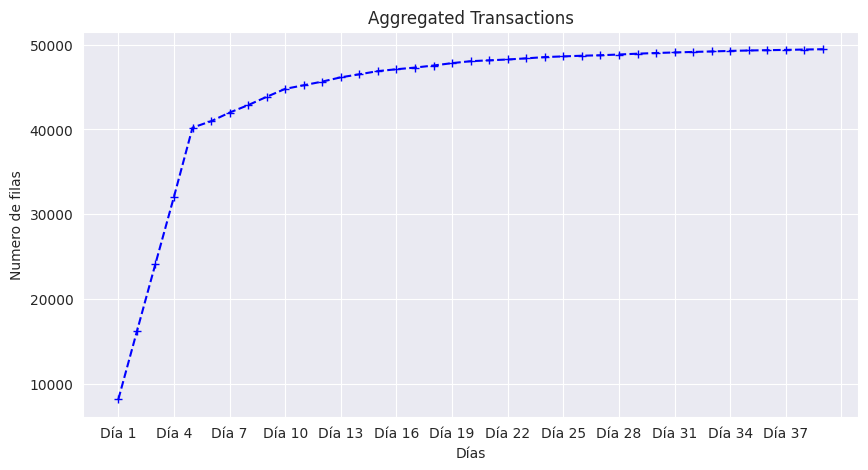

In [ ]:
sns.set_style("darkgrid")

plt.figure(figsize=(10, 5))
plt.plot(aggregatedtransactions, color='blue', linestyle='--', marker='+')
plt.xticks(ticks=range(len(f1scorel)), labels=[f'Día {i+1}' for i in range(len(f1scorel))])
plt.title('Aggregated Transactions')
plt.xlabel('Días')
plt.ylabel('Numero de filas')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=20))

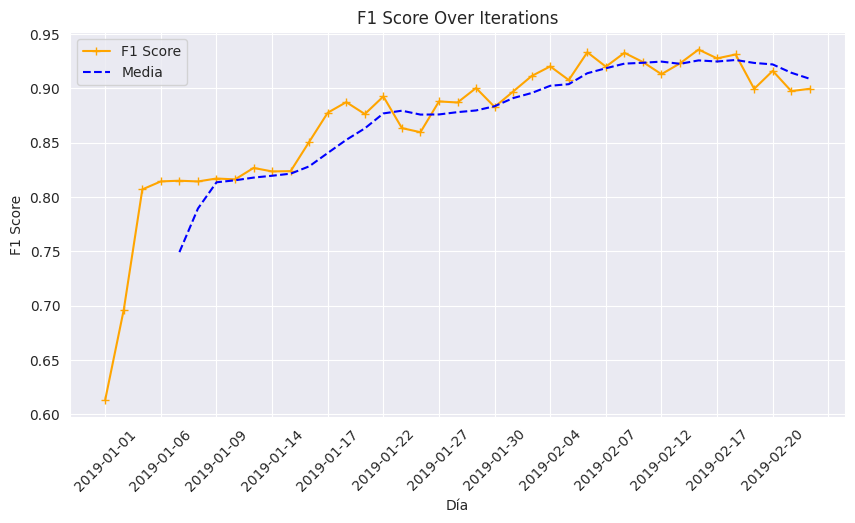

In [ ]:
sns.set_style("darkgrid")

plt.figure(figsize=(10, 5))
plt.plot(f1scorel, color='orange', linestyle='-', marker='+', label='F1 Score')

window_size = 5
moving_avg = np.convolve(f1scorel, np.ones(window_size) / window_size, mode='valid')
plt.plot(range(window_size - 1, len(f1scorel)), moving_avg, color='blue', linestyle='--', label='Media')

plt.xticks(ticks=range(len(f1scorel)), labels=daysf)
plt.title('F1 Score Over Iterations')
plt.xlabel('Día')
plt.ylabel('F1 Score')

plt.legend(loc='best')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=20))

plt.xticks(rotation=45)

plt.show()

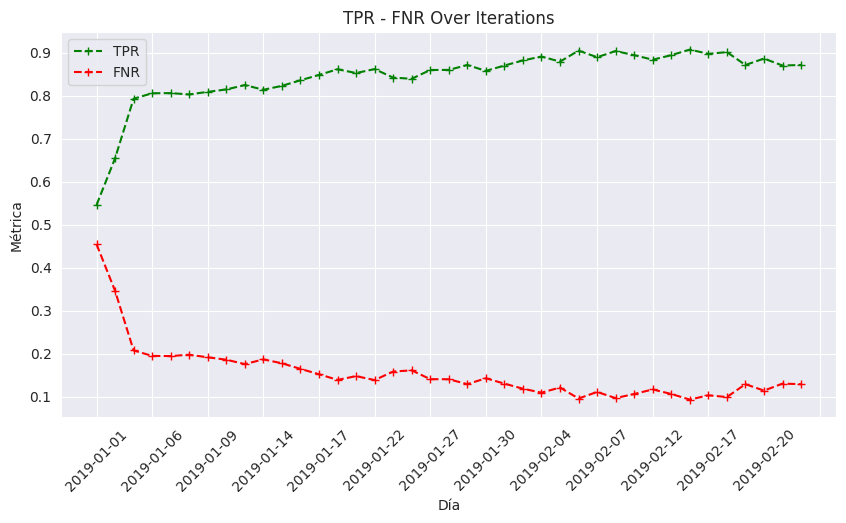

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(tprl, color='green', linestyle='--', marker='+', label='TPR')
plt.plot(fnrl, color='red', linestyle='--', marker='+', label='FNR')

plt.xticks(ticks=range(len(f1scorel)), labels=daysf, rotation=45)

plt.title('TPR - FNR Over Iterations')
plt.xlabel('Día')
plt.ylabel('Métrica')

plt.legend(loc='best')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=20))

plt.show()

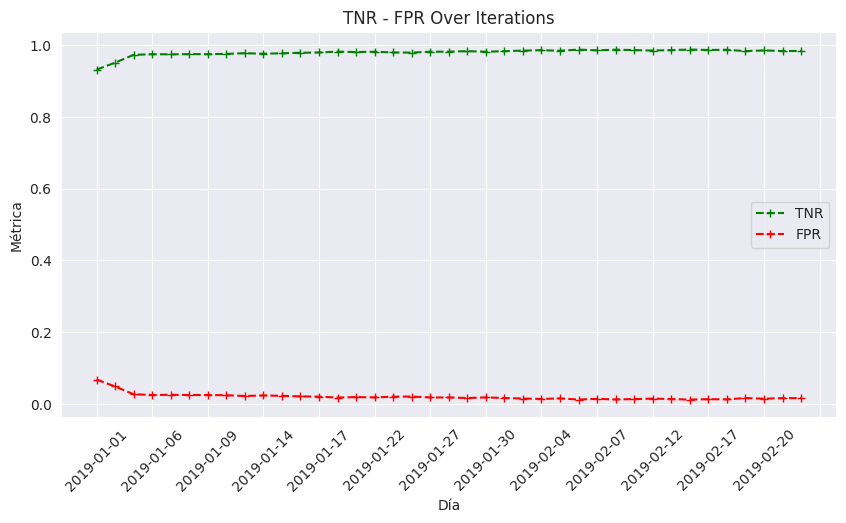

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(tnrl, color='green', linestyle='--', marker='+', label='TNR')
plt.plot(fprl, color='red', linestyle='--', marker='+', label='FPR')

plt.xticks(ticks=range(len(f1scorel)), labels=daysf, rotation=45)
plt.title('TNR - FPR Over Iterations')
plt.xlabel('Día')
plt.ylabel('Métrica')

plt.legend(loc='best')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=20))

plt.show()

**t-SNE**

In [ ]:
X_final_selected = combined_samples_final.drop(columns=['Originator', 'Anomaly'])
y_final_selected = combined_samples_final['Anomaly']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final_selected)

tsne = TSNE(n_components=2, random_state=42,perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

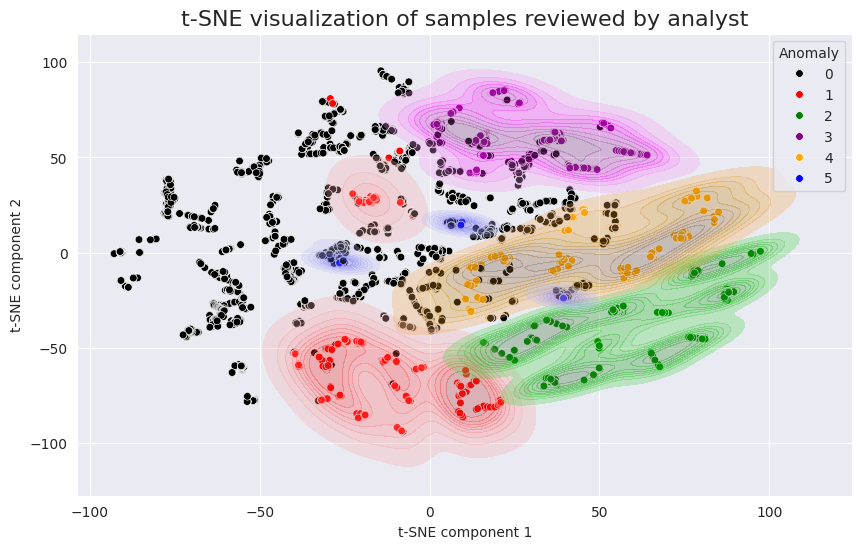

In [ ]:
color_map = {
    0: 'black',
    1: 'red',
    2: 'green',
    3: 'purple',
    4: 'orange',
    5: 'blue'
}

bw_adjust_values = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.5,
    4: 1.5,
    5: 0.3
}

plt.figure(figsize=(10, 6))

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_final_selected, palette=color_map, s=30)

for anomaly_class in np.unique(y_final_selected):
    class_points = X_tsne[y_final_selected == anomaly_class]

    if anomaly_class != 0:
        sns.kdeplot(x=class_points[:, 0], y=class_points[:, 1], color=color_map[anomaly_class], fill=True, alpha=0.3, bw_adjust=bw_adjust_values[anomaly_class])

plt.title('t-SNE visualization of samples reviewed by analyst', fontsize=16)
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

plt.legend(title='Anomaly', loc='upper right')

plt.show()


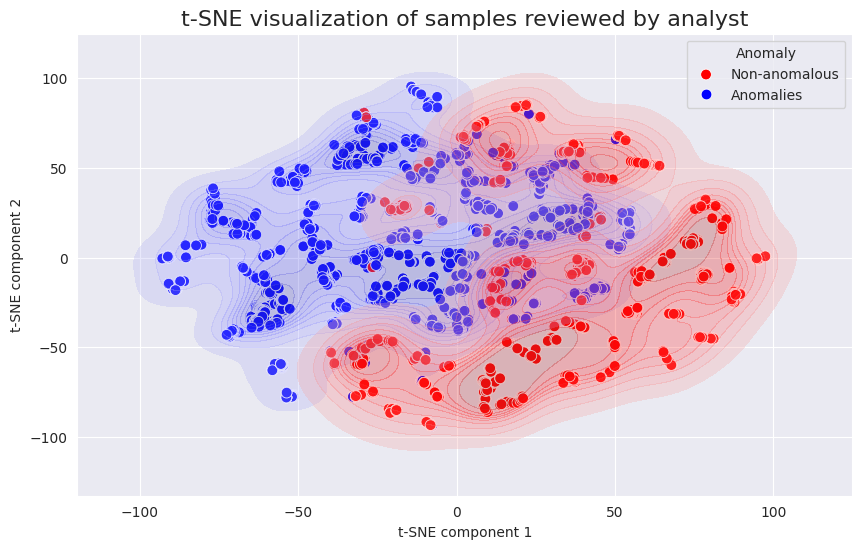

In [ ]:
y_final_selected_binary = y_final_selected.apply(lambda x: 0 if x == 0 else 1)

plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y_final_selected_binary,
    palette={0: 'blue', 1: 'red'},  # 0 en azul, anomalías en rojo
    legend='full',
    s=60
)

for anomaly_class in np.unique(y_final_selected_binary):
    class_points = X_tsne[y_final_selected_binary == anomaly_class]

    if anomaly_class == 0:
        sns.kdeplot(x=class_points[:, 0], y=class_points[:, 1], color='blue', fill=True, alpha=0.3)
    else:
        sns.kdeplot(x=class_points[:, 0], y=class_points[:, 1], color='red', fill=True, alpha=0.3)

plt.title('t-SNE visualization of samples reviewed by analyst', fontsize=16)
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

plt.legend(title='Anomaly', labels=['Non-anomalous', 'Anomalies'], loc='upper right')

plt.show()


In [ ]:
#df_results
combined_samples_final

,Originator,Weekday,Hour,Morning,Evening,Night,Anomaly,num_transactions,total_amount_traded,transactions_count_small_amount,transactions_count_round_amount,transactions_count_amount_sell,transactions_count_amount_buy,cash_out_withdrawal_security_out,simpletranfer,inputoutput_delta
0,Client_066,1,7,1,0,0,1,1.723065e-06,810.830000,1.0,0.0,1.000000,0.000000,810.830000,810.830000,-1.000000
1,Client_126,1,11,1,0,0,1,3.446131e-06,763.445000,1.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000
2,Client_212,1,15,0,1,0,1,1.723065e-06,743.840000,1.0,0.0,1.000000,0.000000,743.840000,743.840000,-1.000000
3,Client_212,1,14,0,1,0,1,1.723065e-06,783.740000,1.0,0.0,1.000000,0.000000,783.740000,783.740000,-1.000000
4,Client_066,1,11,1,0,0,1,2.067679e-05,805.333333,1.0,0.0,0.333333,0.666667,276.075833,276.075833,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7108,Client_385,3,9,1,0,0,1,5.176400e-08,830.450000,1.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000
7109,Client_286,0,7,1,0,0,1,5.176400e-08,793.500000,1.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000
7110,Client_215,4,16,0,1,0,1,5.176400e-08,765.280000,1.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000
7111,Client_304,4,11,1,0,0,1,5.176400e-08,746.550000,1.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000
